In [1]:
pwd

'/Users/edwardterrell/Desktop/Training/kindle/strava'

In [97]:
%matplotlib inline
from IPython.core.display import HTML
css = open('css/style-table.css').read() + open('css/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [98]:
import requests
import json
import time
import os
from pprint import pprint
import datetime

import pandas as pd
pd.set_option('display.precision', 1)
import warnings
warnings.filterwarnings("ignore", message=".*will drop timezone.*")

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns, process_new_data, save_data
from zones import get_zones_for_id, build_week_summary
from plots_details import display_detail_week

# import graphics programs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,6)}) # for all future plots

import sys
sys.executable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [99]:
from token_manager import get_valid_access_token
import requests

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Access token expired. Refreshing...
Using access token: 8b0a2a928055b8b5f3328744c96e362f0e69e69e
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


### Load dataframes

In [100]:
# select year of pickle file e.g. ("data/strava_data_2025.pkl")
# select 'empty' to start new dfs from scratch
# Reload dfs and confirm lengths
strava_df = pd.read_pickle("data/strava_data_2024.pkl")
strava_zone_df = pd.read_pickle("data/strava_zone_data_2024.pkl")

print(len(strava_df))
print(len(strava_zone_df))

14
14


In [101]:
# last entry date
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,10639829371,"Calpe D3 Coastal loop: Xabia, Denia",2024-01-27,136.0,2024-01-27 08:29:19+00:00,81.1,206.8,28.0,1.4,0.0,287.9,29.4,2024-01-22,195.9,847.9,639.0


### Update a specific activity

### Recent activities only!

In [102]:
# select date to start new activities data collection
startdate_string = '2024-01-27'
enddate_string = '2024-02-28'
num_of_activities_for_upload = 50

# change date to unix integer format with mktime
start_date = int(time.mktime(time.strptime(startdate_string, '%Y-%m-%d')))
end_date = int(time.mktime(time.strptime(enddate_string, '%Y-%m-%d')))
print(f"Start Date: {startdate_string}")
print(f"End Date:   {enddate_string}")

# strava url
url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "before": end_date,
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []

stop_fetching = False
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data or stop_fetching:
        # breaks out of while loop
        break
        
    for activity in data:
        # change date to unix integer format
        activity_date = int(datetime.datetime.strptime(activity['start_date'], "%Y-%m-%dT%H:%M:%SZ").timestamp())
        print(f"ID: {activity['id']}, Name: {activity['name']}, Date: {activity['start_date']}")
        # set number of activites (strava maximum is 100/15 minutes)
        if len(activities) >= num_of_activities_for_upload:
            stop_fetching = True
            # breaks out of for loop only
            break
        activities.append(activity)
    params["page"] += 1

In [104]:
# Build out strava_df with only the necessary columns
recent_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
recent_df = recent_df.loc[:,cols_needed]
recent_df = recent_df.sort_values('start_date',ascending=False) 

# This step does the comparison between recent_df and strava_df
# strava_df holds previously saved data

if strava_df.empty:
    new_activities_df = recent_df.copy()
else:
    new_activities_df = recent_df[~recent_df.id.isin(strava_df.id)].copy()
    
# display df of new activities
print()
new_activities_df

,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
0,10847129648,Calpe D28 Alcalali-Pedreguer-Gata-Lliber loop,67677.8,11568,1122.0,Ride,5.8,110.0,143.0,97.0,2024-02-27T08:47:27Z
1,10840428080,Calpe D27 Eds variation Coll de Rates,76417.6,12542,1342.0,Ride,6.1,119.5,151.0,201.0,2024-02-26T08:44:14Z
2,10833585792,Calpe D26 Xabia - Pedreguer with backroads,71825.1,12519,998.0,Ride,5.7,104.5,140.0,98.0,2024-02-25T08:49:07Z
3,10826345696,Calpe D25 Bernia loop in the high winds….,60584.2,10714,1145.0,Ride,5.7,115.8,153.0,171.0,2024-02-24T08:34:19Z
4,10819657469,Coastline walk and good eats,8914.8,7607,181.0,Walk,1.2,141.0,219.0,63.0,2024-02-23T08:30:42Z
5,10813885810,Calpe D24 Gata de Gorgos and Beni-Beni circuit,88872.1,14974,1246.0,Ride,5.9,120.8,172.0,337.0,2024-02-22T08:29:27Z
6,10807502253,Calpe D23 Coll de Rate and itinerant meanderings,89129.0,14726,1612.0,Ride,6.1,111.4,158.0,187.0,2024-02-21T08:57:24Z
7,10800546122,Calpe D22 La Vall de Laguar - reverse,81332.5,14281,1399.0,Ride,5.7,107.3,153.0,139.0,2024-02-20T08:45:20Z
8,10793833311,Calpe D21 car rally ended route,97893.8,16180,1355.0,Ride,6.0,110.3,189.0,164.0,2024-02-19T09:04:54Z
9,10787042249,Calpe D20 Coll de Rates,73711.2,11858,1349.0,Ride,6.2,113.6,219.0,171.0,2024-02-18T08:49:53Z


In [105]:
strava_df = process_new_data(new_activities_df, strava_df)

### Get Zone data

In [106]:
# Recent zone data
# Create a new_zone dataframe for recent activities
cols = ['id', 'name', 'date', 'suffer_score','start_date']
new_data = strava_df.loc[:,cols]
new_zone_df = pd.DataFrame(new_data, columns=cols)

mask = new_zone_df['id'].isin(new_activities_df['id'])
new_zone_df = new_zone_df[mask]

In [108]:
len(new_zone_df) < 100

31

In [107]:
# Note that get_zones_for_id is a function in zones.py
# There is a max limit of 100 calls per 15 minutes set by Strava for this function
if len(new_zone_df) < 100:
    # Apply function to fetch zone data per activity ID
    zone = new_zone_df['id'].apply(lambda current_id: get_zones_for_id(current_id, access_token))
    zone.index = new_zone_df['id']

    # Add in summary zones: moderate and intense
    zone['moderate'] = zone[['Zone1', 'Zone2']].sum(axis=1)
    zone['intense'] = zone[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)

    # display new zone info
    zone
else:
     print("❌ Number of calls exceeds Strava's 15-minute limit (max 100))
     print ("Try limiting the number of calls")

Fetching zones for activity: 10847129648
Fetching zones for activity: 10840428080
Fetching zones for activity: 10833585792
Fetching zones for activity: 10826345696
Fetching zones for activity: 10819657469
Fetching zones for activity: 10813885810
Fetching zones for activity: 10807502253
Fetching zones for activity: 10800546122
Fetching zones for activity: 10793833311
Fetching zones for activity: 10787042249
Fetching zones for activity: 10778642840
Fetching zones for activity: 10773397436
Fetching zones for activity: 10767132818
Fetching zones for activity: 10760077679
Fetching zones for activity: 10759266991
Fetching zones for activity: 10753630786
Fetching zones for activity: 10745967532
Fetching zones for activity: 10739279955
Fetching zones for activity: 10721267862
Fetching zones for activity: 10715037757
Fetching zones for activity: 10707842682
Fetching zones for activity: 10701560154
Fetching zones for activity: 10696288345
Fetching zones for activity: 10694821777
Fetching zones f

,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense
id,,,,,,,
10847129648,27.5,144.9,19.8,6.8e-01,0.0e+00,172.3,20.4
10840428080,7.3,126.6,49.2,2.6e+01,0.0e+00,133.9,75.1
10833585792,56.2,130.1,22.3,0.0e+00,0.0e+00,186.3,22.3
10826345696,17.7,89.7,54.7,1.6e+01,8.3e-02,107.4,71.2
10819657469,22.1,25.2,12.4,1.2e+01,5.6e+01,47.2,79.6
10813885810,34.4,97.3,48.6,3.5e+01,3.4e+01,131.7,117.9
10807502253,41.0,134.9,53.0,8.7e+00,7.7e+00,175.9,69.5
10800546122,45.9,154.8,15.2,2.1e+01,1.1e+00,200.7,37.3
10793833311,36.5,201.8,16.9,0.0e+00,1.4e+01,238.3,31.3


In [109]:
new_zone_df = pd.merge(new_zone_df, zone, left_on='id',right_index=True)

In [110]:
# Get the Sunday start of the week for each date (time set to midnight)
new_zone_df['week_start'] = new_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

#new_zone_df.columns are now matched with strava_zone_df
new_zone_df = pd.concat ([new_zone_df, strava_zone_df], axis=0)

new_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,10847129648,Calpe D28 Alcalali-Pedreguer-Gata-Lliber loop,2024-02-27,97.0,2024-02-27 08:47:27+00:00,27.5,144.9,19.8,0.7,0.0,172.3,20.4,2024-02-26,NaN,NaN,NaN


In [111]:
# This drops all weekly_ cols since they are all recalculated later
only_cols = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start']
new_zone_df = new_zone_df[only_cols]
#new_zone_df.head()

# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = new_zone_df.sort_values(['week_start', 'start_date'])

In [112]:
# Calculate cumulative sum within each week for weekly_ cols
cumulative_cols = ['intense', 'moderate', 'suffer_score']
cumulative_sums = (
temp
    .groupby('week_start')[cumulative_cols]
    .cumsum()
    .add_prefix('weekly_')  # rename columns if needed
)
# Add start_date column for reference
cumulative_sums['start_date'] = temp['start_date']
cumulative_sums = cumulative_sums.sort_values('start_date', ascending = False)
cumulative_sums.head(3)
strava_zone_df = pd.merge(new_zone_df,cumulative_sums, left_on ='start_date', right_on='start_date')

,weekly_intense,weekly_moderate,weekly_suffer_score,start_date
0,95.5,306.3,298.0,2024-02-27 08:47:27+00:00
1,75.1,133.9,201.0,2024-02-26 08:44:14+00:00
2,429.1,1087.6,1159.0,2024-02-25 08:49:07+00:00


### Plotting Section

In [113]:
week_summary = build_week_summary(strava_zone_df)
week_summary.sort_values('week_start',ascending=False).head()

,week_start,weekly_intense,weekly_moderate,weekly_suffer_score,week
8,2024-02-26,95.5,306.3,298.0,Feb 26
7,2024-02-19,429.1,1087.6,1159.0,Feb 19
6,2024-02-12,283.8,937.6,994.0,Feb 12
5,2024-02-05,208.3,1019.5,744.0,Feb 05
4,2024-01-29,352.8,1173.3,1163.0,Jan 29


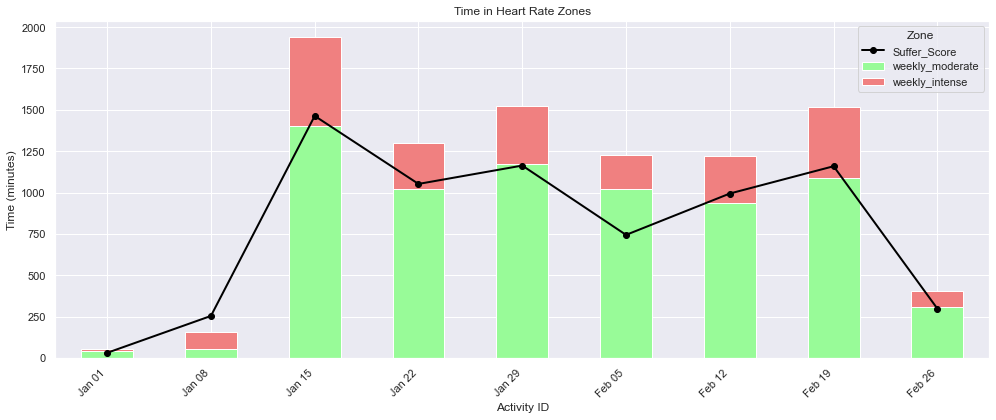

In [114]:
import matplotlib.pyplot as plt

ax = week_summary.plot(
    y=['weekly_moderate','weekly_intense'],
    x='week',
    kind='bar', 
    stacked=True, 
    figsize=(14, 6), 
    color=['#98FB98', '#F08080']
)

# Overlay line plot for 'weekly_suffer_score'
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="Suffer_Score"  
)

plt.title("Time in Heart Rate Zones");
plt.xlabel("Activity ID");
plt.ylabel("Time (minutes)");
plt.legend(title="Zone");
plt.xticks(rotation=45, ha='right');
plt.tight_layout();
plt.show();

### Drilling down a specific week

In [49]:
# default start is current week
start = week_summary.sort_values('week_start',ascending=False).iloc[0,0]
start = "2024-01-15" # <-- select custom week starting date

In [115]:
week_df, zone_week_df = display_detail_week(start, strava_df, strava_zone_df)
week_df[['id','name', 'date', 'sport', 'distance', 'time', 'speed', 'elev_gain',
       'avg_HR', 'max_HR', 'suffer_score']]
zone_week_df[['name','date','Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start',
       'weekly_intense']]

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score
4,10600329993,Tenerife D8 Churros and Leche-Leche,2024-01-21,Ride,28.9,2:34,11.3,2998.7,96.3,122.0,39.0
3,10595406083,Tenerife D7 Teide from the north,2024-01-20,Ride,61.1,5:29,11.1,8087.3,119.6,166.0,424.0
2,10588186702,Tenerife D6 Arico (but no loop due to stormy c...,2024-01-19,Ride,47.4,3:37,13.0,4248.0,105.0,146.0,103.0
1,10582706259,Tenerife D5 Masca,2024-01-18,Ride,53.3,5:08,10.4,7099.7,109.9,181.0,219.0
0,10576769362,"Tenerife D4 El Teide loop, Inside the Caldera",2024-01-17,Ride,75.3,6:15,12.0,8765.7,115.2,143.0,341.0
9,10569939382,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,Ride,45.8,3:55,11.6,5394.4,110.3,134.0,165.0
8,10563366548,Tenerife D2 Arico Loop,2024-01-15,Ride,63.7,5:19,12.0,6026.2,107.2,139.0,172.0


,name,date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense
36,Tenerife D8 Churros and Leche-Leche,2024-01-21,55.5,98.5,0.3,0.0,0.0,154.0,0.3,2024-01-15,539.8
37,Tenerife D7 Teide from the north,2024-01-20,38.2,105.1,146.9,36.0,3.5,143.3,186.4,2024-01-15,539.6
38,Tenerife D6 Arico (but no loop due to stormy c...,2024-01-19,43.0,155.4,16.4,3.1,0.0,198.4,19.5,2024-01-15,353.2
39,Tenerife D5 Masca,2024-01-18,65.0,168.7,51.1,21.2,3.0,233.6,75.3,2024-01-15,333.7
40,"Tenerife D4 El Teide loop, Inside the Caldera",2024-01-17,32.6,194.2,135.2,13.5,0.0,226.8,148.7,2024-01-15,258.4
41,"Tenerife D3 Santiago del Teide, coastal route ...",2024-01-16,34.2,133.7,67.8,0.0,0.0,167.9,67.8,2024-01-15,109.7
42,Tenerife D2 Arico Loop,2024-01-15,49.0,228.6,41.5,0.4,0.0,277.6,41.9,2024-01-15,41.9


In [116]:
# Set number of rows to display
pd.set_option('display.max_rows', 20) #if set to None this will show all
pd.set_option('display.min_rows', 20)  # adjust to help override auto-truncation

strava_zone_df[['name','date','intense']]
pd.reset_option('display.max_rows')

,name,date,intense
0,Calpe D28 Alcalali-Pedreguer-Gata-Lliber loop,2024-02-27,20.4
1,Calpe D27 Eds variation Coll de Rates,2024-02-26,75.1
2,Calpe D26 Xabia - Pedreguer with backroads,2024-02-25,22.3
3,Calpe D25 Bernia loop in the high winds….,2024-02-24,71.2
4,Coastline walk and good eats,2024-02-23,79.6
5,Calpe D24 Gata de Gorgos and Beni-Beni circuit,2024-02-22,117.9
6,Calpe D23 Coll de Rate and itinerant meanderings,2024-02-21,69.5
7,Calpe D22 La Vall de Laguar - reverse,2024-02-20,37.3
8,Calpe D21 car rally ended route,2024-02-19,31.3
9,Calpe D20 Coll de Rates,2024-02-18,72.5


### Saving data

In [117]:
# verify before saving
strava_df.head(1)
strava_zone_df.head(1)
print(len(strava_df))
print(len(strava_zone_df))

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
0,10847129648,Calpe D28 Alcalali-Pedreguer-Gata-Lliber loop,2024-02-27,Ride,42.1,3:12,13.1,3681.1,110.0,143.0,97.0,192.8,5.8,2024-02-27 08:47:27+00:00


,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
0,10847129648,Calpe D28 Alcalali-Pedreguer-Gata-Lliber loop,2024-02-27,97.0,2024-02-27 08:47:27+00:00,27.5,144.9,19.8,0.7,0.0,172.3,20.4,2024-02-26,95.5,306.3,298.0


45
45


### Use save_data, and year

In [118]:
# Select year for saving
# Data will be saved to: data/{today}
save_data(strava_df, strava_zone_df, 2024)

Data saved in folder: data/2025-07-18
